# Multifractal Analysis

In [1]:
import numpy as np
import nolds
import scipy.io
import mne
import pandas as pd
import seaborn as sns
from numpy import array, int32, uint16
import pyqtgraph as pg
from scipy.io import loadmat
from scipy import stats
import matplotlib.pyplot as plt
import antropy as ent
from antropy import higuchi_fd
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation
from pyrqa.time_series import TimeSeries
from pyrqa.result import RQAResult
from pyrqa.opencl import OpenCL
from pyrqa.settings import Settings
from pyrqa.time_series import TimeSeries
from pyrqa.neighbourhood import FixedRadius
from pyrqa.settings import Settings
from pyrqa.time_series import TimeSeries
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.image_generator import ImageGenerator
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from MFDFA import MFDFA
import matplotlib.pyplot as plt
from antropy import higuchi_fd

In [3]:
# Define the file paths
eeg_df_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/DataFrames/eeg_df.csv' 
merged_stim_df_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/DataFrames/merged_stim_df.csv'

# Load the data into dataframes
eeg_df = pd.read_csv(eeg_df_path)
merged_stim_df = pd.read_csv(merged_stim_df_path)

print("EEG DataFrame:")
print(eeg_df.head())  # Displays the first few rows of eeg_df
print()

print("Merged Stim DataFrame:")
print(merged_stim_df.head())  # Displays the first few rows of merged_stim_df

EEG DataFrame:
            Fp1           Fpz           Fp2           F7         F3  \
0 -21295.988649 -20109.716727 -24153.383752  3189.340060 -45.189275   
1 -21303.747077 -20120.746154 -24163.864012  3178.880909 -56.702035   
2 -21315.466571 -20130.126577 -24171.944343  3164.903807 -69.465350   
3 -21317.809594 -20131.044726 -24174.790986  3159.478572 -73.214591   
4 -21325.798142 -20137.522181 -24179.985166  3144.934679 -84.871628   

            Fz          F4           F8          FC5          FC1  ...  \
0 -8525.066680 -642.128590  3487.913621  6324.956639  6503.012177  ...   
1 -8532.499649 -651.966372  3477.011771  6315.078704  6496.522520  ...   
2 -8544.315275 -663.772856  3463.194795  6302.391524  6483.178723  ...   
3 -8545.873916 -666.109249  3457.870782  6297.212341  6481.970244  ...   
4 -8551.164448 -671.761501  3450.466406  6283.925509  6477.045614  ...   

            P7           P3          Pz           P4           P8  \
0  3374.048029 -3617.197964 -611.584742 -166

In [ ]:
import matplotlib.pyplot as plt

# Plotting EEG data with stimulus events
plt.figure(figsize=(12, 6))

# Plot EEG data
plt.plot(eeg_df['Time'], eeg_df['Fpz'], label='Fpz')
plt.title('EEG data (Fpz) over time')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.legend()

# Plot stimulus start and stop times with swapped colors
for start_time in stim_start_times:
    plt.axvline(start_time, color='g', linestyle='--', linewidth=2, label='Stim Start')  # Green for Stim Start
for stop_time in stim_stop_times:
    plt.axvline(stop_time, color='r', linestyle='--', linewidth=2, label='Stim Stop')  # Red for Stim Stop

plt.tight_layout()
plt.show()


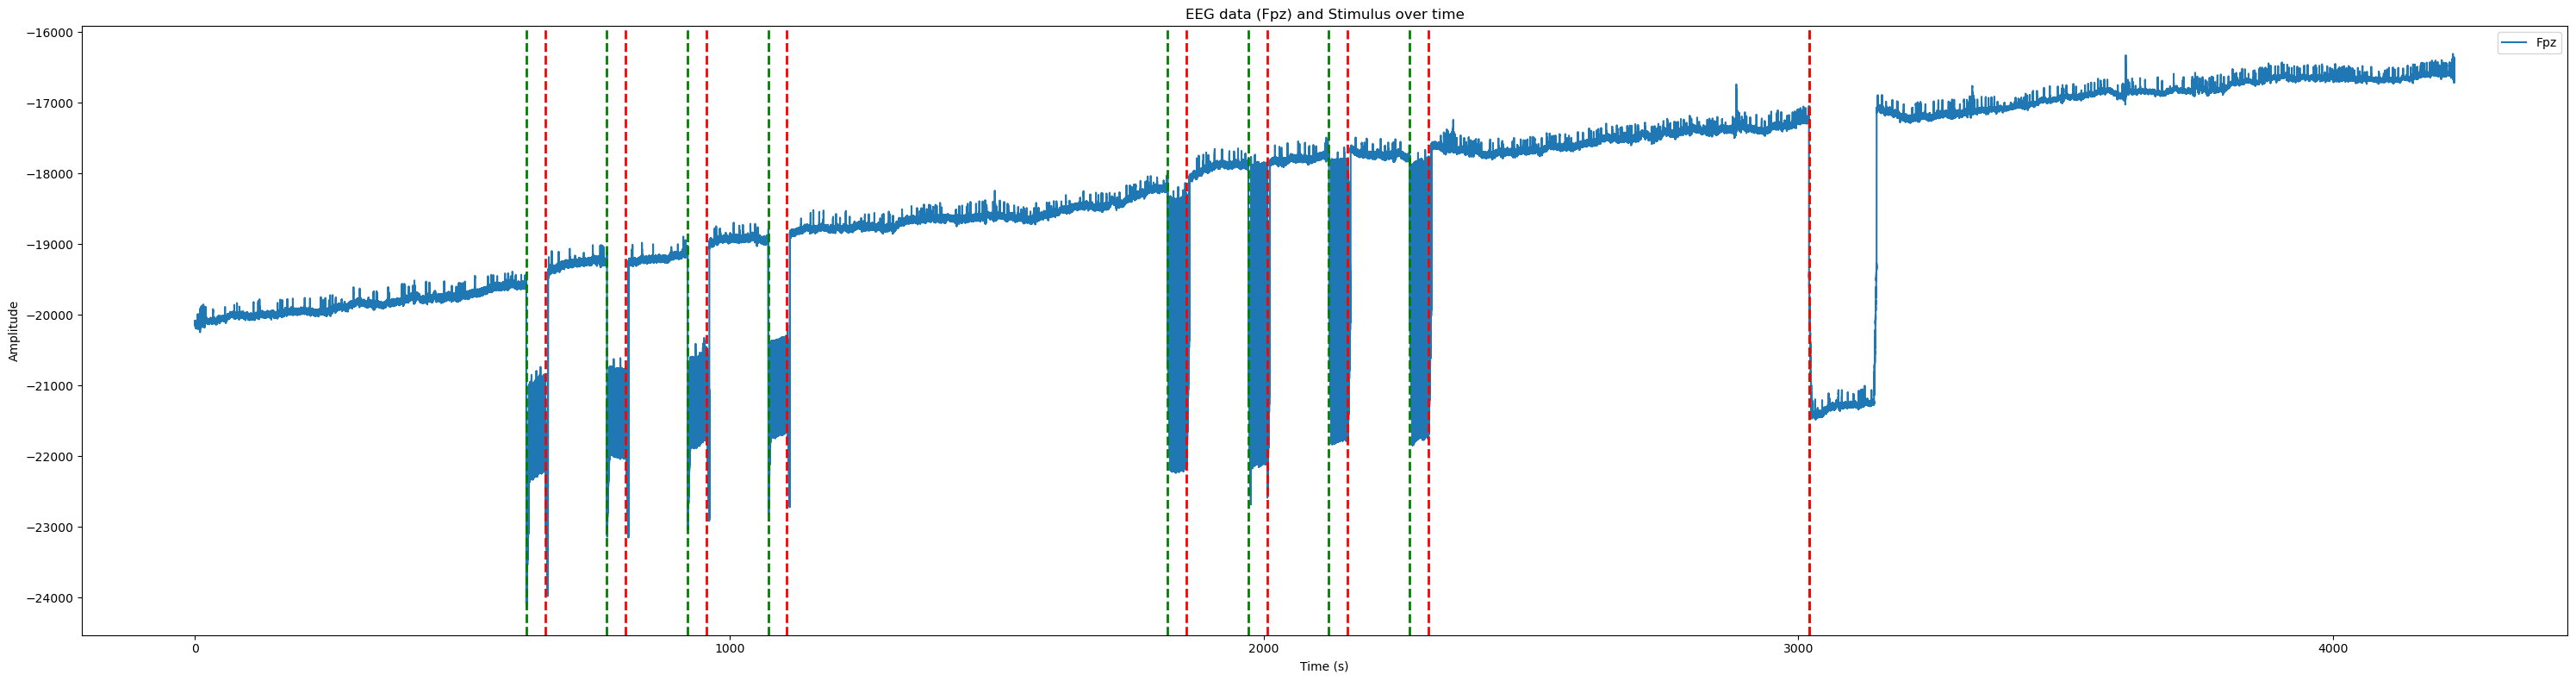

In [7]:
# Assuming the EEG data was sampled at 1000 Hz
sampling_rate = 1000

# Create a time vector for the EEG data
eeg_time = np.arange(0, len(eeg_df) / sampling_rate, 1 / sampling_rate)

# Add the time column to the EEG dataframe
eeg_df['Time'] = eeg_time

# Create lists to store stimulus start and stop times
stim_start_times = []
stim_stop_times = []

# Loop through the merged_stim_df and extract start and stop times
for index, row in merged_stim_df.iterrows():
    if row['EventDescription'] == 'Stim Start':
        stim_start_times.append(row['Time'])
    elif row['EventDescription'] == 'Stim Stop':
        stim_stop_times.append(row['Time'])

# Define the channels to plot
channels_to_plot = eeg_df.columns[1:6]  # This will select the first five channels (excluding the 'Time' column)

# Plotting EEG data with stimulus events
plt.figure(figsize=(30, 8))  # Widening the plot by two

# Plot EEG data
for channel in channels_to_plot:
    plt.plot(eeg_df['Time'], eeg_df[channel], label=channel)

plt.title('EEG data and Stimulus over time')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.legend()

# Plot stimulus start and stop times with swapped colors
for start_time in stim_start_times:
    plt.axvline(start_time, color='g', linestyle='--', linewidth=2, label='Stim Start')  # Green for Stim Start
for stop_time in stim_stop_times:
    plt.axvline(stop_time, color='r', linestyle='--', linewidth=2, label='Stim Stop')  # Red for Stim Stop

plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Assuming the EEG data was sampled at 1000 Hz
sampling_rate = 1000

# Create a time vector for the EEG data
eeg_time = np.arange(0, len(eeg_df) / sampling_rate, 1 / sampling_rate)

# Add the time column to the EEG dataframe
eeg_df['Time'] = eeg_time

# Create a Plotly figure
fig = go.Figure()

# Plot EEG data
fig.add_trace(go.Scatter(x=eeg_df['Time'], y=eeg_df['Fpz'], mode='lines', name='EEG (Fpz)'))

# Add stimulus start and stop shapes
for index, row in merged_stim_df.iterrows():
    if row['EventDescription'] == 'Stim Start':
        fig.add_shape(
            type="line",
            x0=row['Time'],
            x1=row['Time'],
            y0=-24000,  # Adjust this value based on your EEG data range
            y1=-16000,  # Adjust this value based on your EEG data range
            line=dict(color='red', width=2, dash='dash'),
        )
    elif row['EventDescription'] == 'Stim Stop':
        fig.add_shape(
            type="line",
            x0=row['Time'],
            x1=row['Time'],
            y0=-24000,  # Adjust this value based on your EEG data range
            y1=-16000,  # Adjust this value based on your EEG data range
            line=dict(color='green', width=2, dash='dash'),
        )

# Update layout for better visibility
fig.update_layout(
    title='EEG data (Fpz) and Stimulus over time',
    xaxis_title='Time (s)',
    yaxis_title='Amplitude',
    height=800,  # Make the window three times taller
)

# Show the plot
fig.show()

# MFDFA

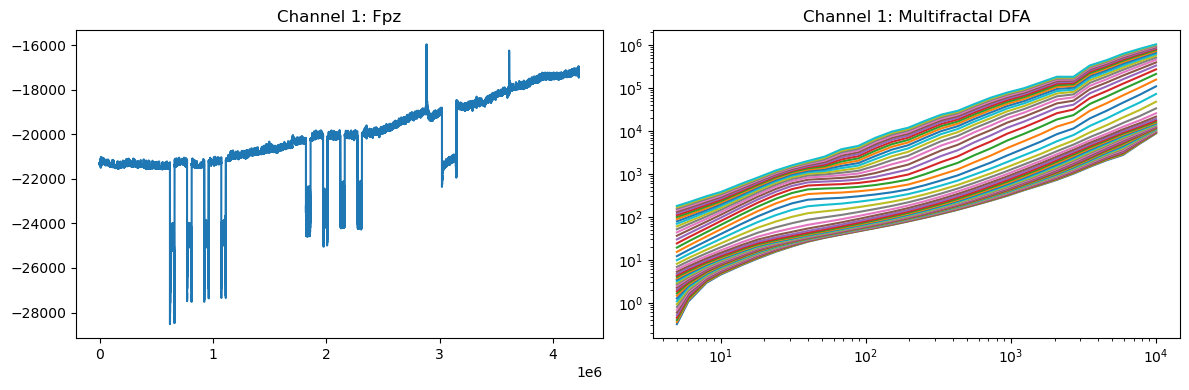

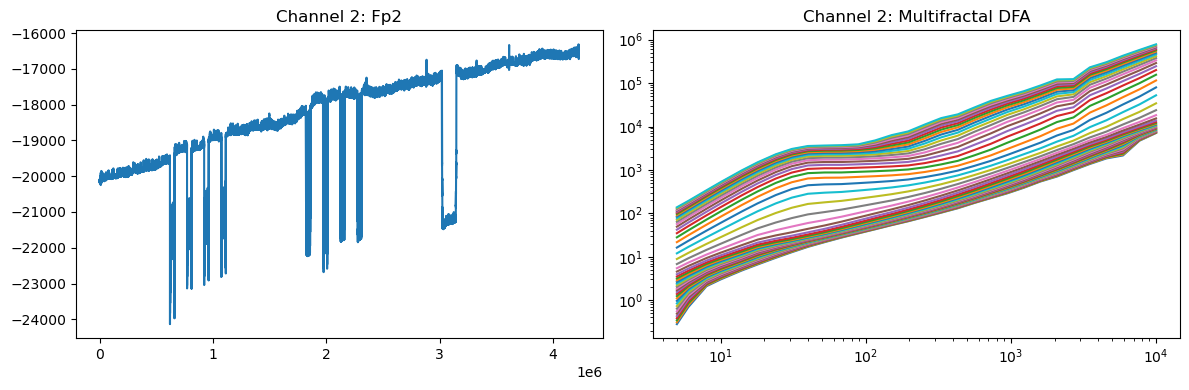

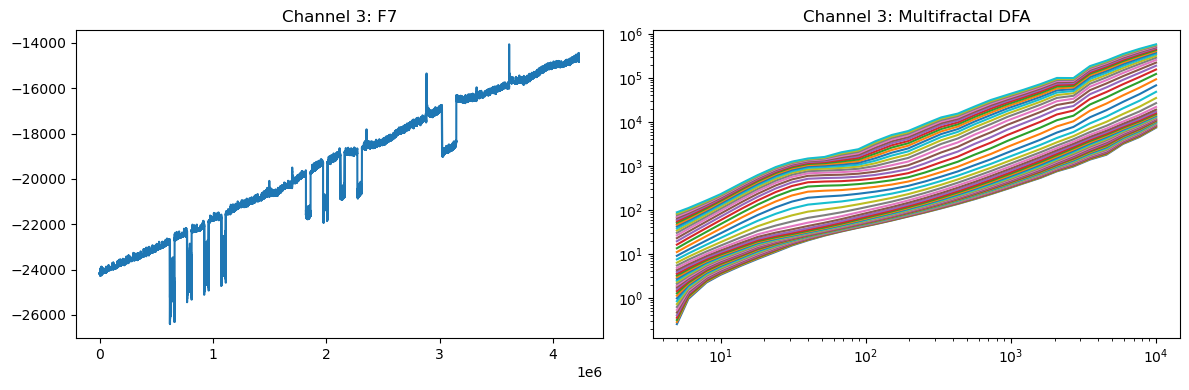

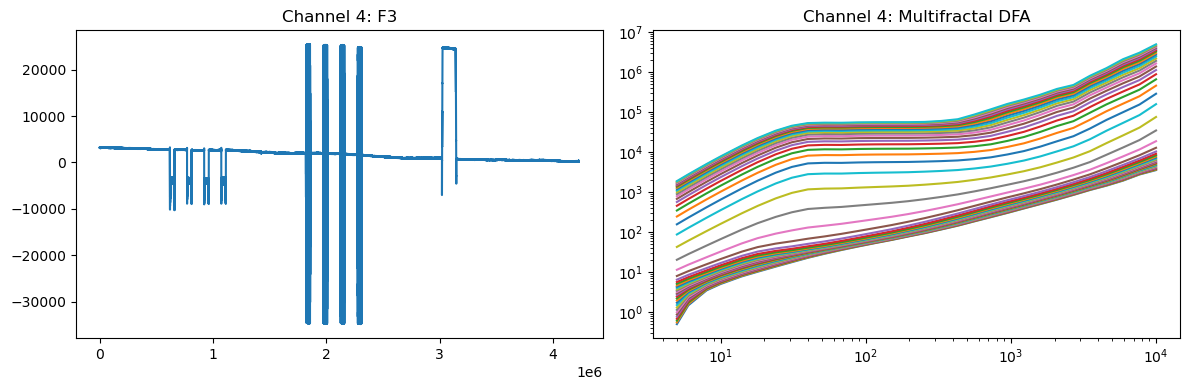

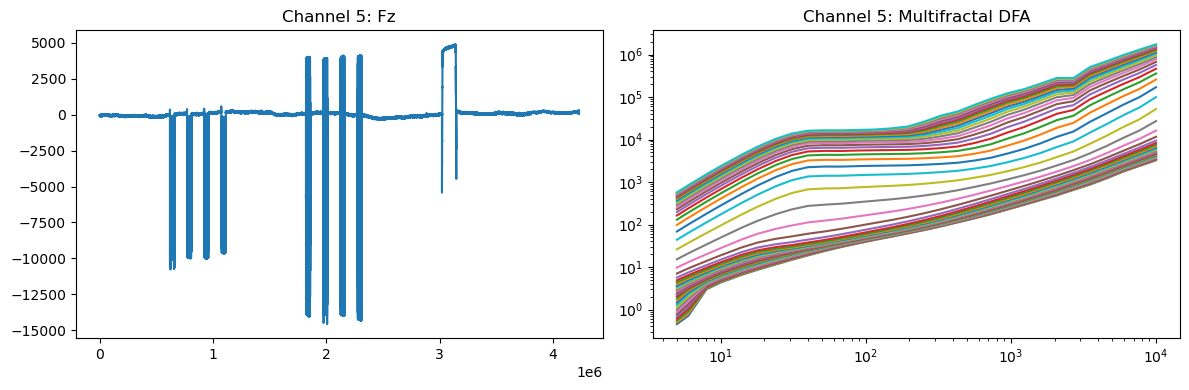

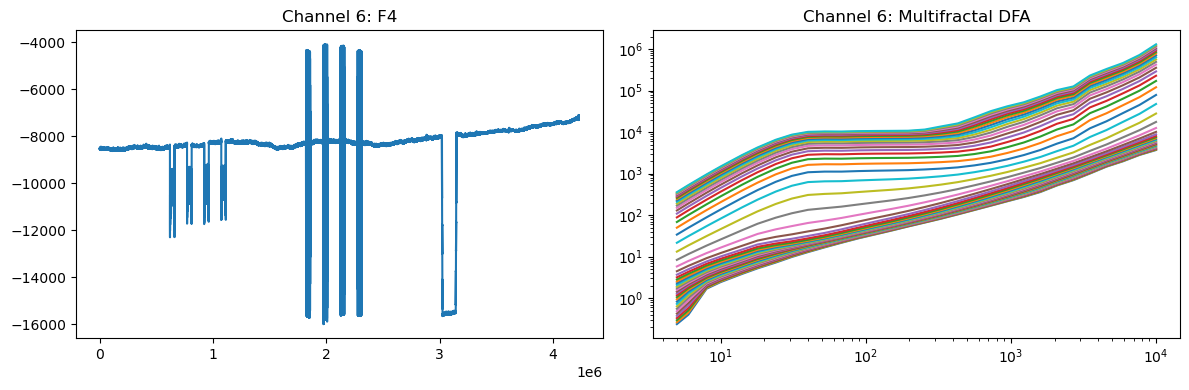

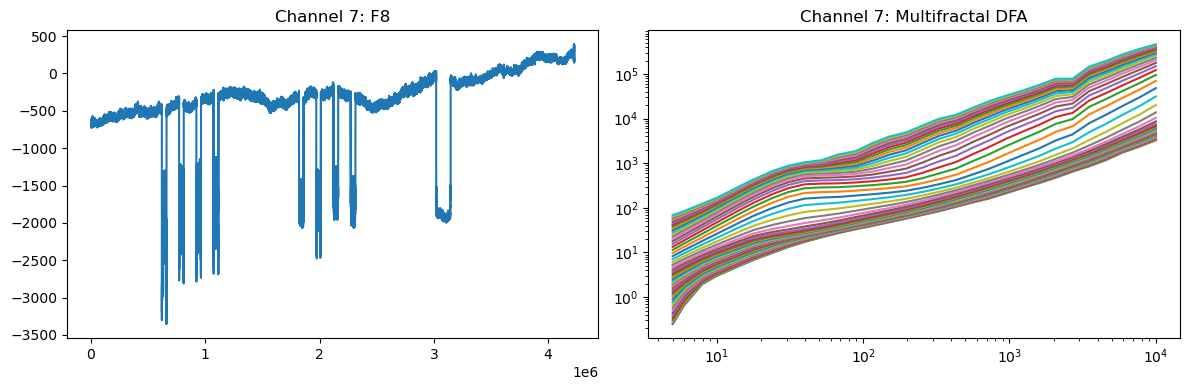

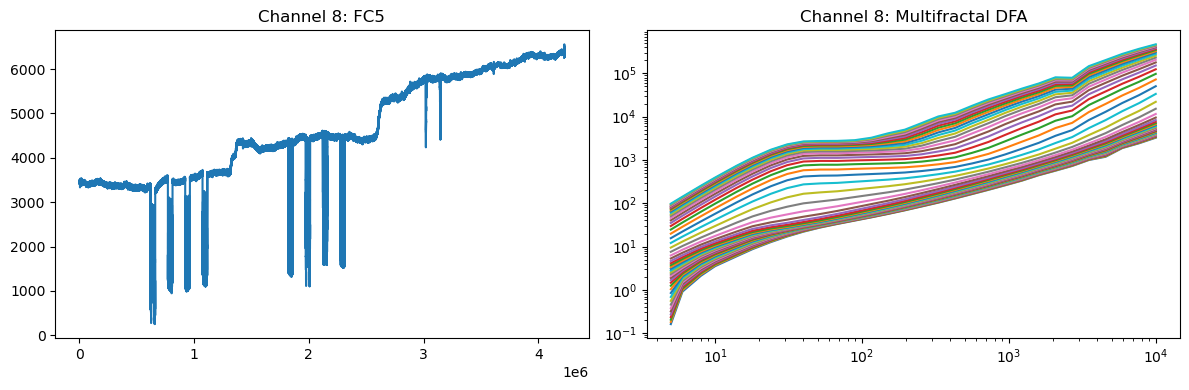

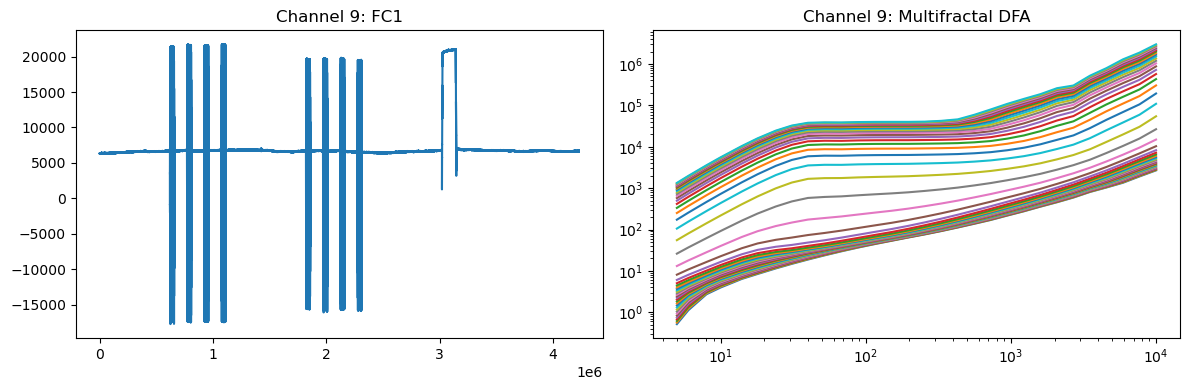

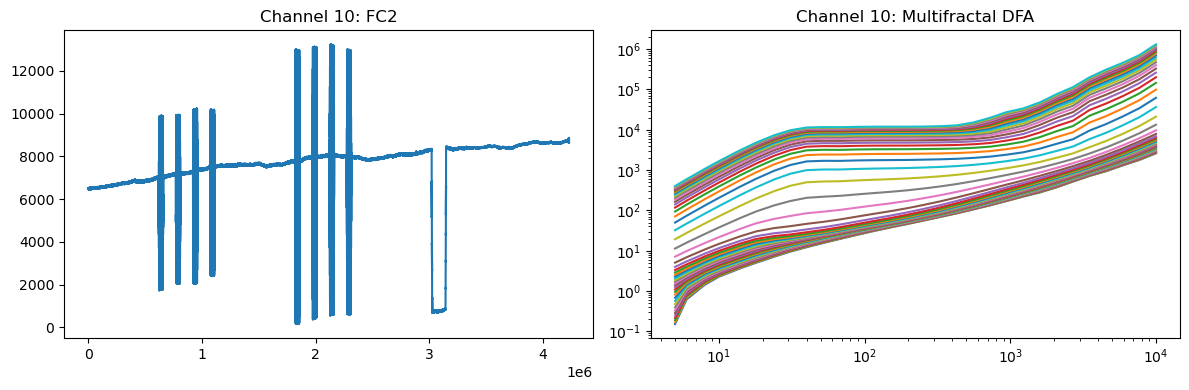

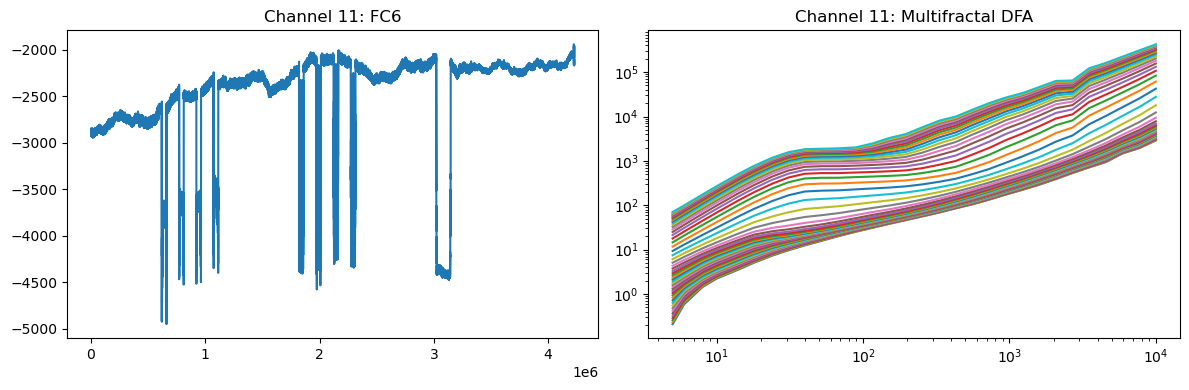

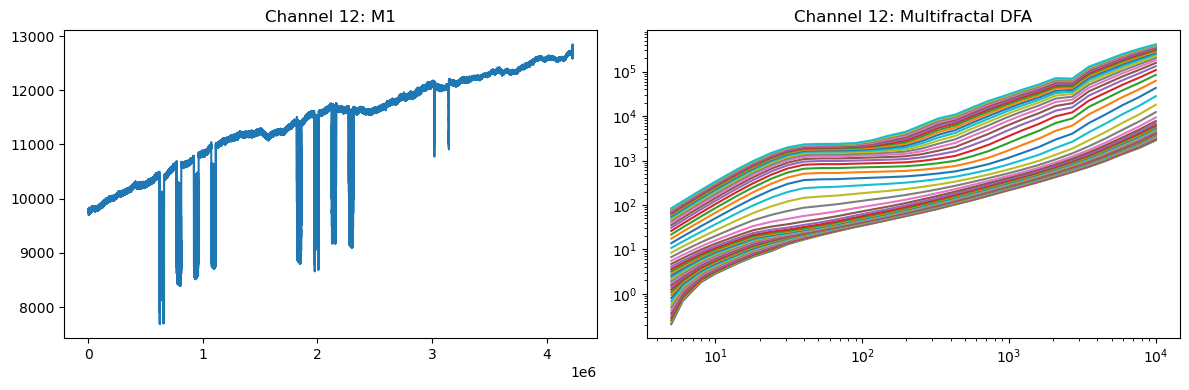

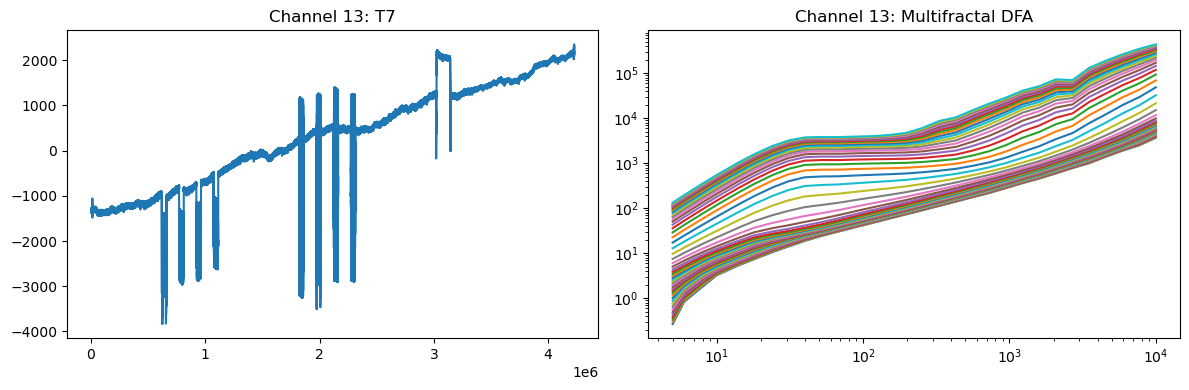

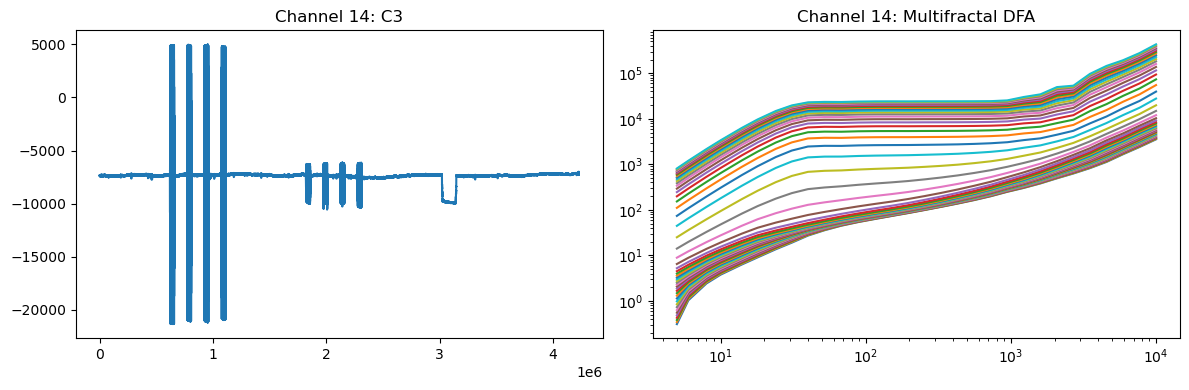

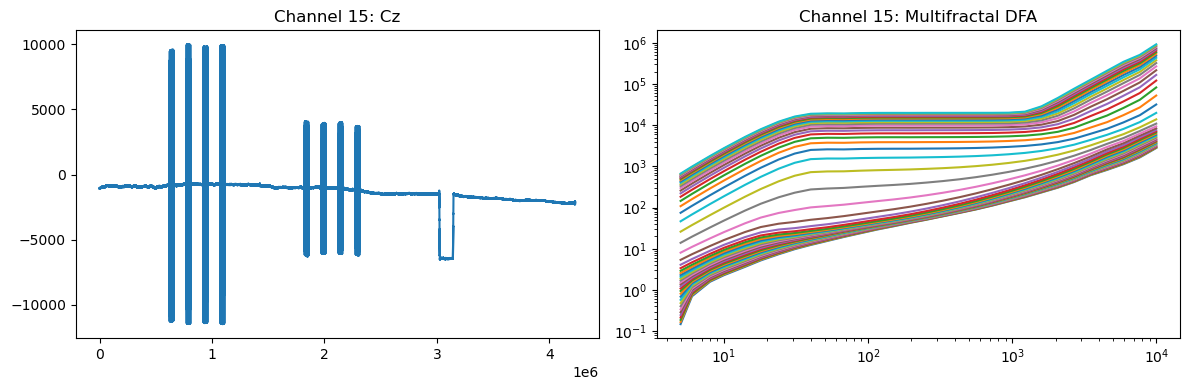

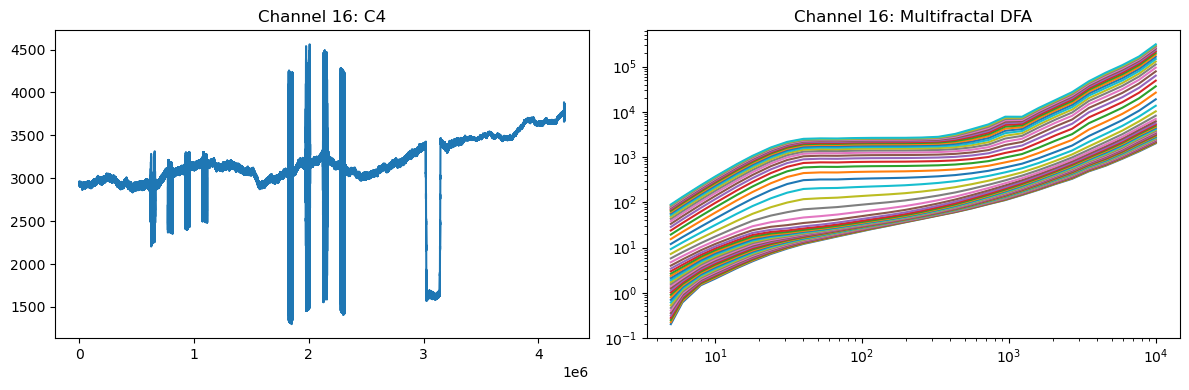

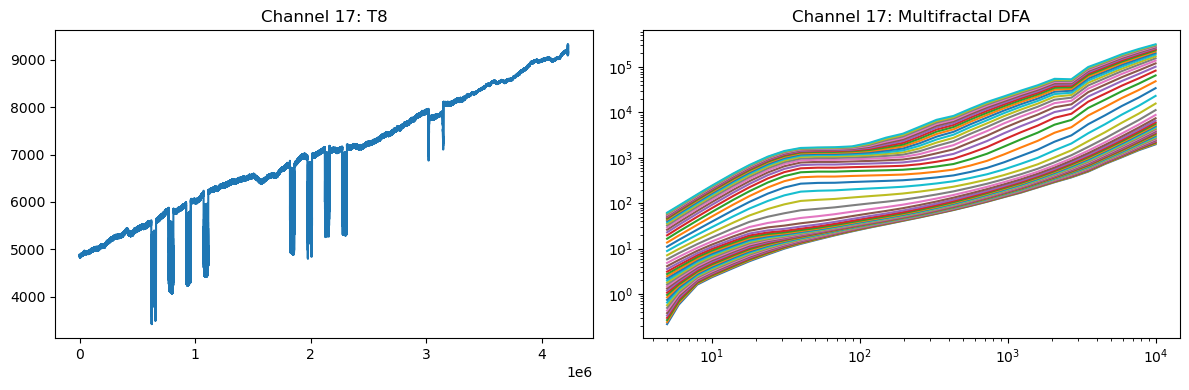

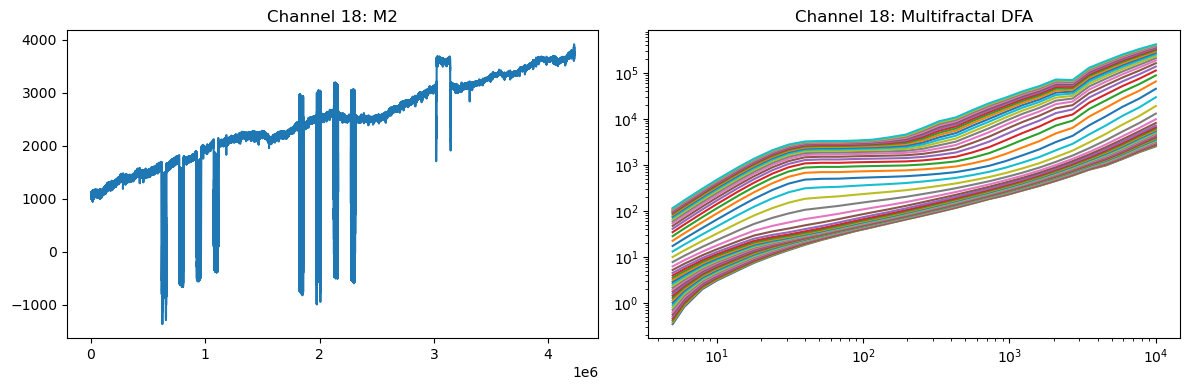

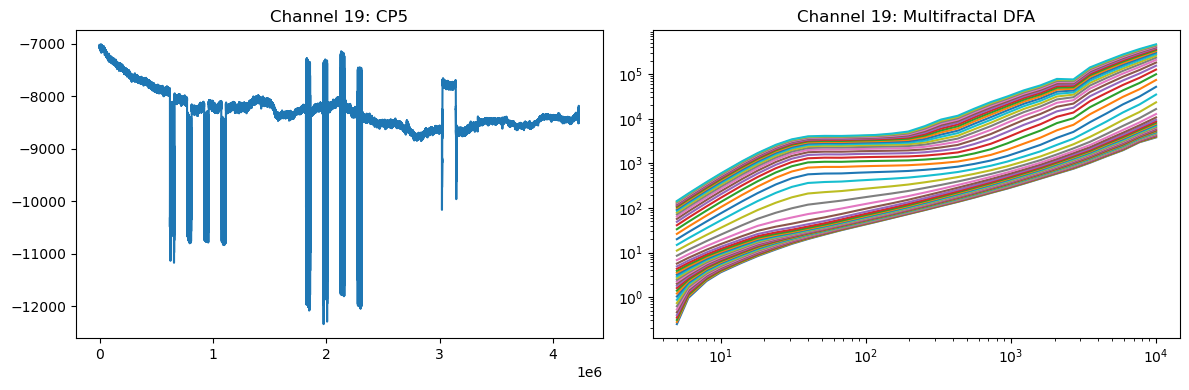

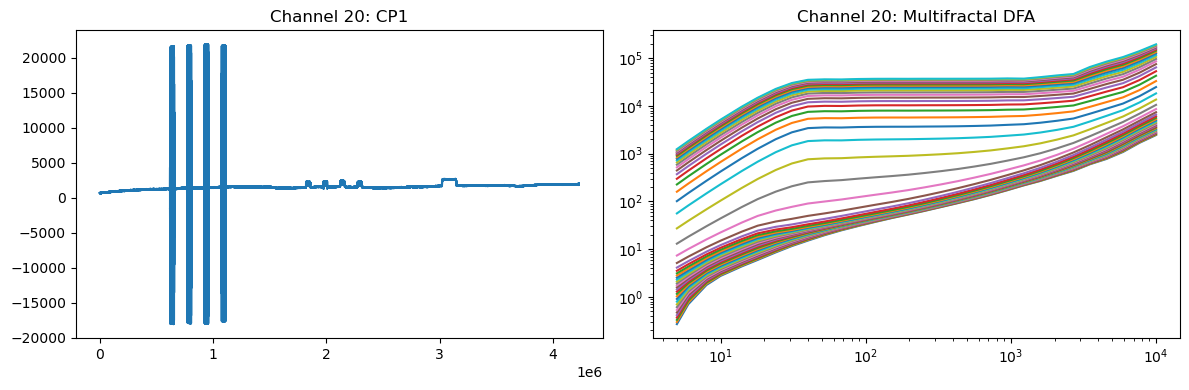

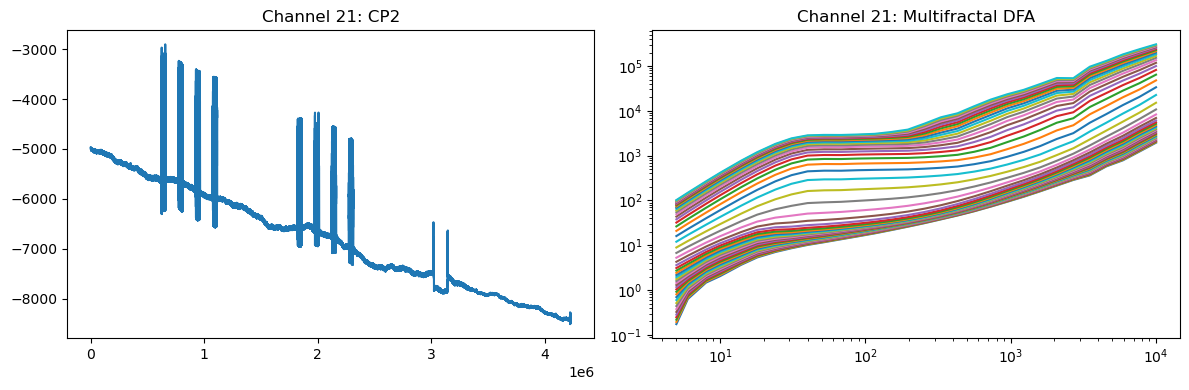

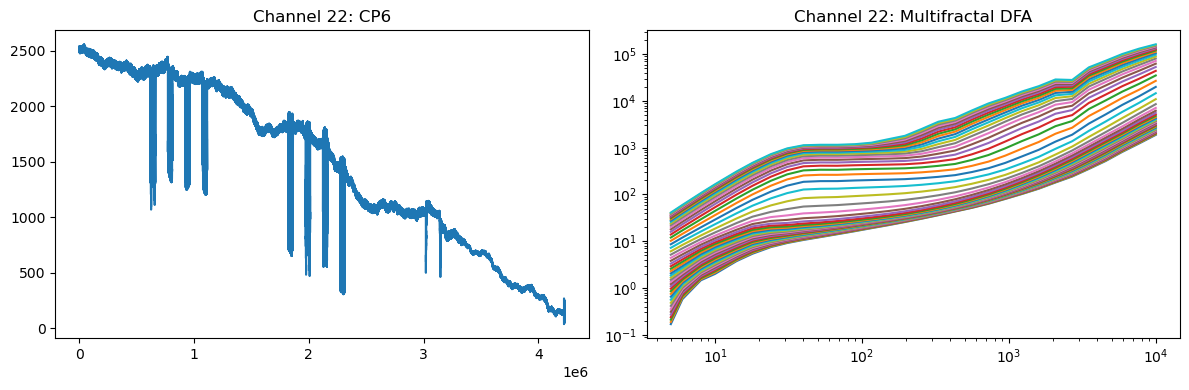

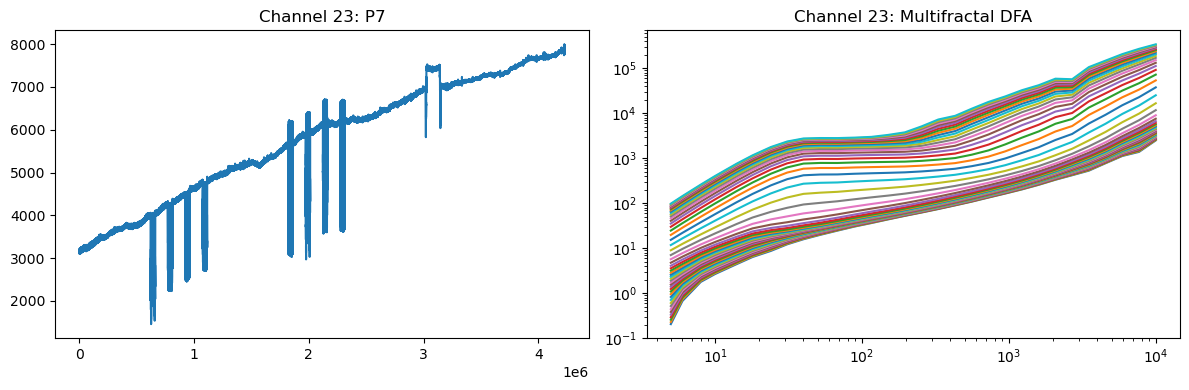

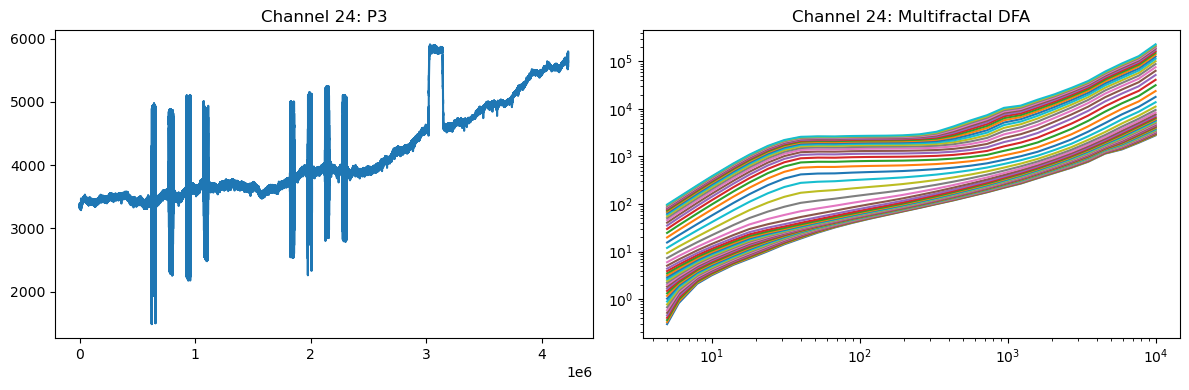

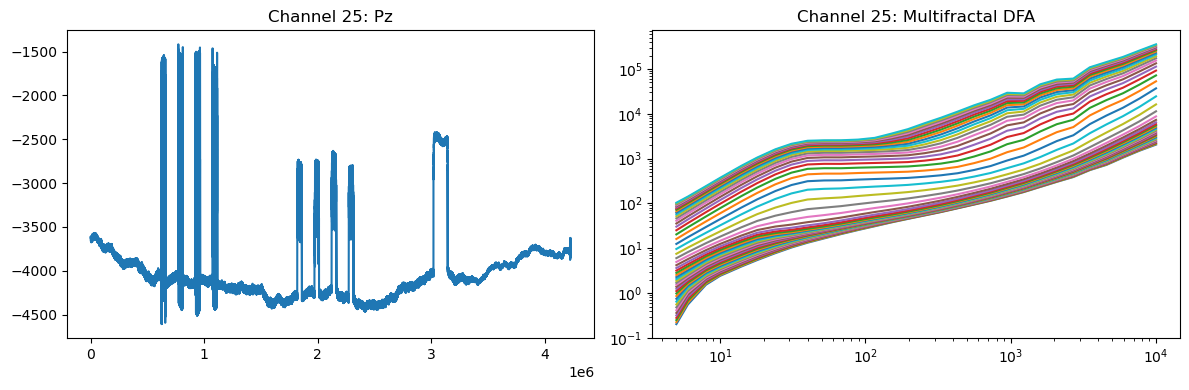

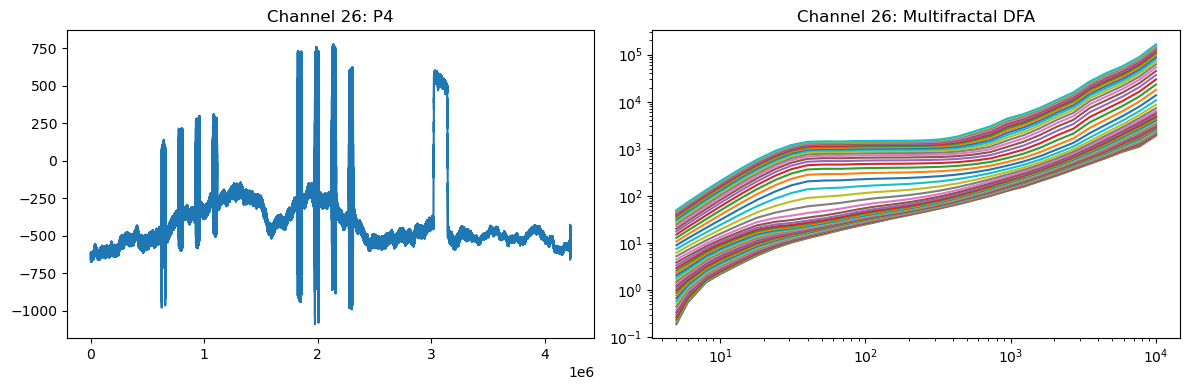

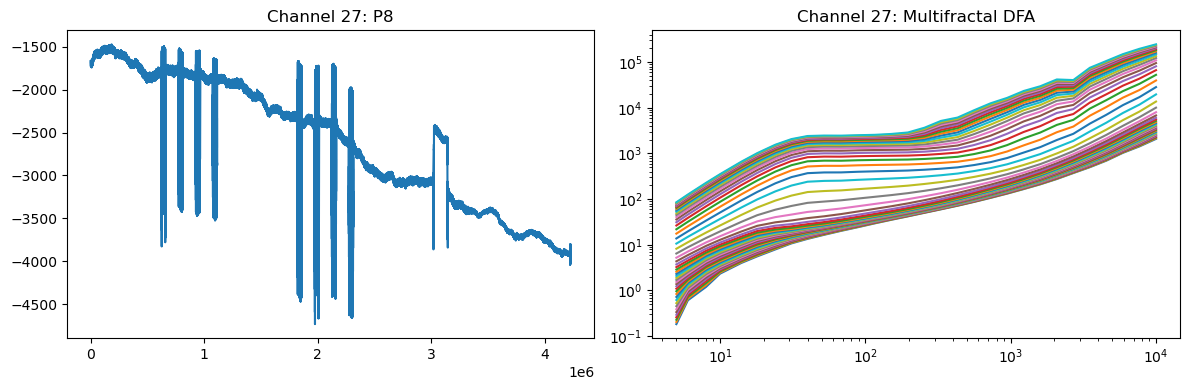

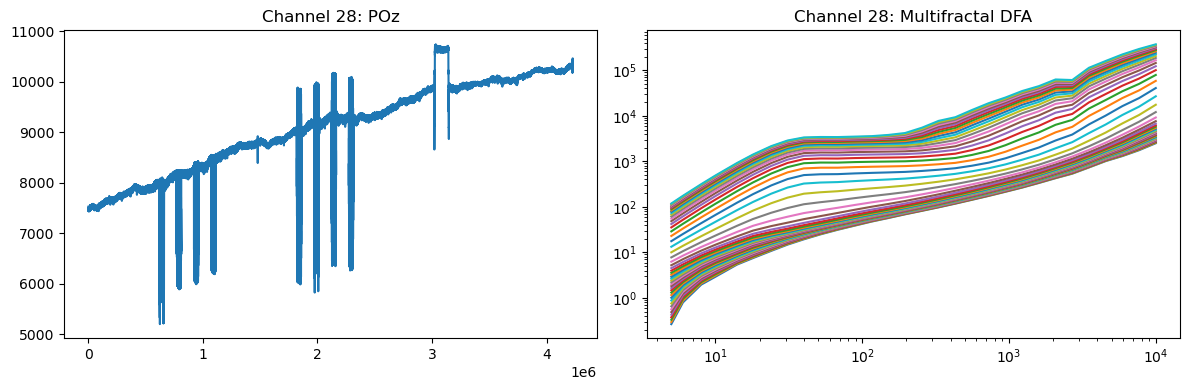

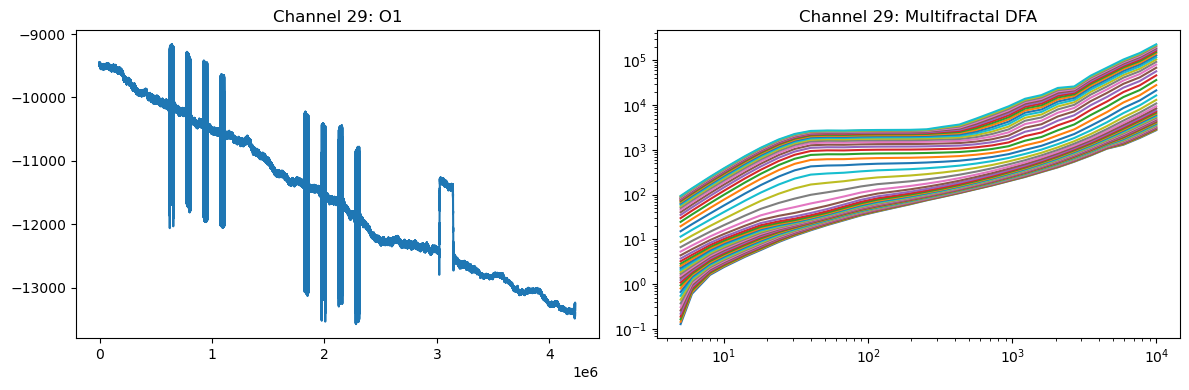

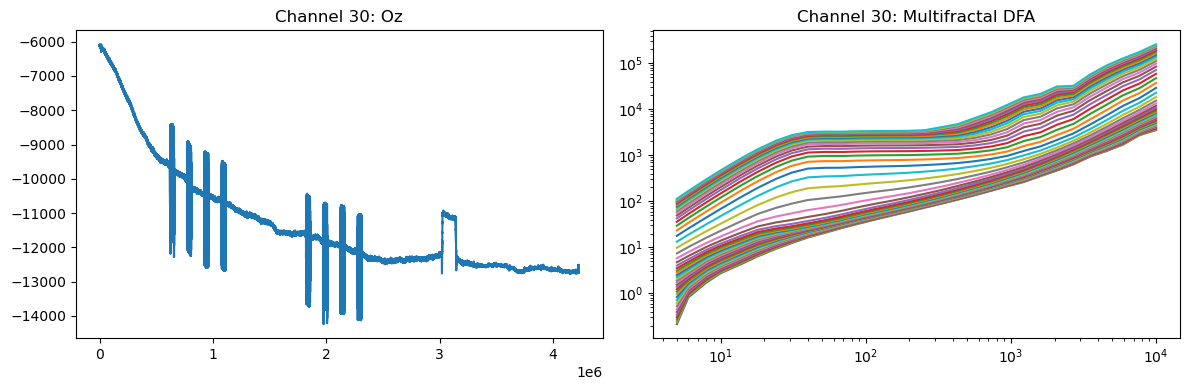

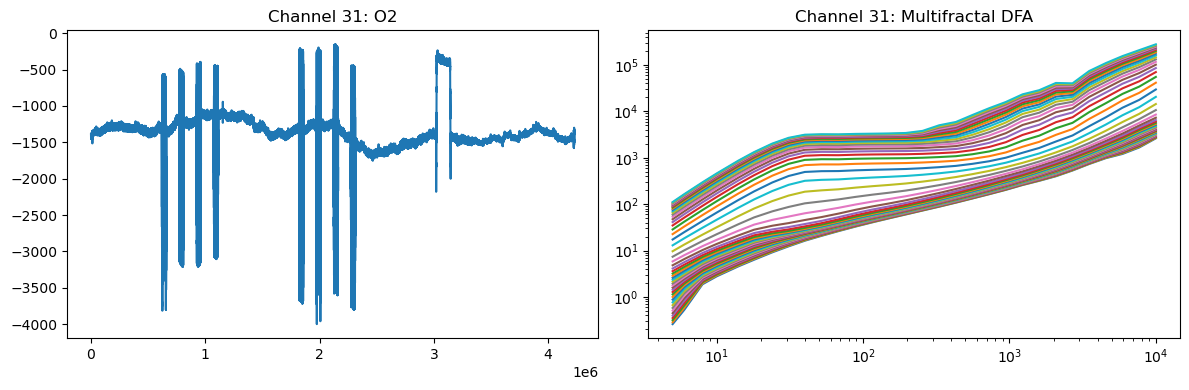

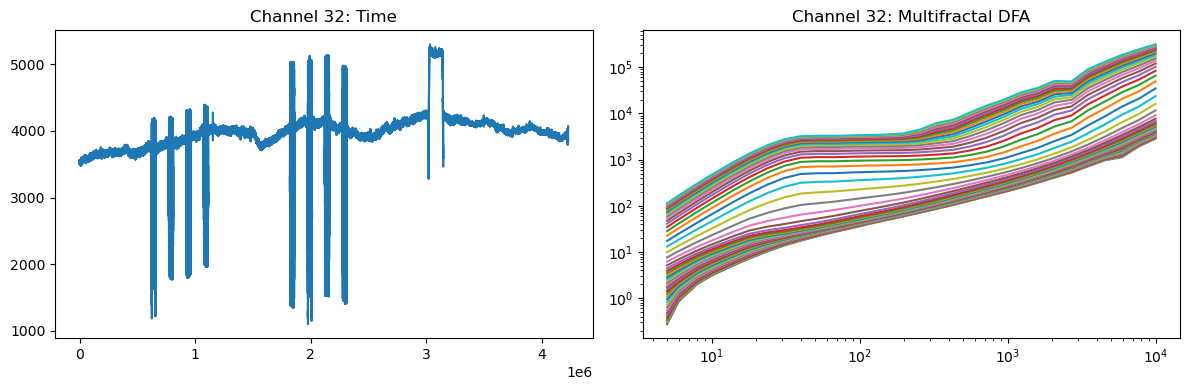

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from MFDFA import MFDFA

# Assuming the EEG data was sampled at 1000 Hz
sampling_rate = 1000

# Load EEG data
eeg_df_values = eeg_df.values[:, :-1]  # Remove the 'Time' column
num_channels = eeg_df_values.shape[1]
channel_labels = eeg_df.columns[1:]

# Calculate multifractal spectrum for the EEG data
lag = np.logspace(0.7, 4, 30).astype(int)
q = np.linspace(-5, 5, 50)

# Define a list to store scale and fluctuation parameters
mfdfa_results = []

# Loop over each channel
for ch in range(num_channels):
    # Select the current channel data
    eeg_data_filtered = eeg_df_values[:, ch]
    
    # Call MFDFA for the current channel data
    scale, fluct = MFDFA(eeg_data_filtered, lag=lag, q=q)

    # Store scale and fluctuation parameters
    mfdfa_results.append((scale, fluct))
    
    # Visualize the results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(eeg_data_filtered)
    plt.title(f"Channel {ch+1}: {channel_labels[ch]}")
    
    plt.subplot(1, 2, 2)
    plt.loglog(scale, fluct)
    plt.title(f"Channel {ch+1}: Multifractal DFA")
    
    plt.tight_layout()
    plt.show()

In [5]:
# Save mfdfa_results to a file
mfdfa_results_dict = {f'channel_{i}': result for i, result in enumerate(mfdfa_results)}

# Save the results to a file
save_dir = '/home/vincent/AAA_projects/MVCS/Neuroscience/MFDFA/'  
np.save(save_dir + 'MFDFA_results.npy', mfdfa_results_dict)

# Hurst Exponents

In [115]:
# Initialize an array to store the Hurst exponent for each channel
num_channels = eeg_df_values.shape[1]
hurst_exponents = np.zeros(num_channels)

# Check if mfdfa_results has data for each channel
if len(mfdfa_results) != num_channels:
    print("Error: MFDFA results do not have data for each channel.")
else:
    # Loop over each channel
    for ch in range(num_channels):
        # Extract the scale and fluctuation parameters for the current channel
        scale, fluct = mfdfa_results[ch]

        # Calculate the mean fluctuation over all time scales
        mean_fluct = np.mean(fluct, axis=0)

        # Print the head (first 10 elements) of scale and mean fluctuation values for the current channel
        print(f"Channel {ch+1} - Scale:", scale[:10])
        print(f"Channel {ch+1} - Mean Fluctuation:", mean_fluct[:10])

        # Fit a line in log-log space to get the Hurst exponent
        H_hat = np.polyfit(np.log(scale)[4:20], np.log(mean_fluct)[4:20], 1)[0]

        # Store the Hurst exponent for the current channel
        hurst_exponents[ch] = H_hat.item()  # Extract the scalar value

    # Specify the file path for saving the Hurst exponents
    file_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/HurstExponents/hurst_exponents.npy'

    # Save the Hurst exponents to the file
    np.save(file_path, hurst_exponents)

    # Print the head (first 10 elements) of the Hurst exponents array
    print("Hurst exponents:", hurst_exponents)

    print("Hurst exponents saved to:", file_path)

Channel 1 - Scale: [ 5  6  8 10 14 18 24 31 40 52]
Channel 1 - Mean Fluctuation: [ 808.78941721  831.00442732  854.7410567   880.12387655  907.28505507
  936.36302415  967.50039245 1000.84106592 1036.52671978 1074.6930805 ]
Channel 2 - Scale: [ 5  6  8 10 14 18 24 31 40 52]
Channel 2 - Mean Fluctuation: [702.95878259 720.23441807 738.61648119 758.18501829 779.01974983
 801.19698379 824.78610711 849.84637455 876.42514008 904.55888951]
Channel 3 - Scale: [ 5  6  8 10 14 18 24 31 40 52]
Channel 3 - Mean Fluctuation: [747.1362778  767.99189053 790.12370047 813.60498171 838.51150602
 864.9218368  892.91779162 922.58511433 954.01441952 987.30251307]
Channel 4 - Scale: [ 5  6  8 10 14 18 24 31 40 52]
Channel 4 - Mean Fluctuation: [486.36037792 496.773076   507.72036538 519.23666113 531.35930219
 544.12894623 557.59006258 571.79156228 586.78762672 602.63883684]
Channel 5 - Scale: [ 5  6  8 10 14 18 24 31 40 52]
Channel 5 - Mean Fluctuation: [414.07400572 422.69823946 431.79658924 441.40679474 

# Montage Setup for EEG Channels

In [104]:
scalp_positions_1010 = {
    'Fp1': (-0.9511, -0.3090),
    'Fpz': (-1.0000, 0.0000),
    'Fp2': (-0.9511, 0.3090),
    'F7': (-0.5878, -0.8090),
    'F3': (-0.8090, -0.5878),
    'Fz': (-0.8090, 0.0000),
    'F4': (-0.8090, 0.5878),
    'F8': (-0.5878, 0.8090),
    'FC5': (-0.4045, -0.8090),
    'FC1': (-0.6545, -0.3090),
    'FC2': (-0.6545, 0.3090),
    'FC6': (-0.4045, 0.8090),
    'M1': (0.1545, -1.0000),
    'T7': (-0.0000, -1.0000),
    'C3': (-0.3090, -0.9511),
    'Cz': (0.0000, -0.8090),
    'C4': (-0.3090, -0.9511),
    'T8': (0.0000, 1.0000),
    'M2': (0.1545, 1.0000),
    'CP5': (0.4045, -0.8090),
    'CP1': (0.6545, -0.3090),
    'CP2': (0.6545, 0.3090),
    'CP6': (0.4045, 0.8090),
    'P7': (0.5878, -0.8090),
    'P3': (0.8090, -0.5878),
    'Pz': (0.8090, 0.0000),
    'P4': (0.8090, 0.5878),
    'P8': (0.5878, 0.8090),
    'POz': (0.9511, 0.0000),
    'O1': (1.0000, -0.3090),
    'Oz': (1.0000, 0.0000),
    'O2': (1.0000, 0.3090)
}

# Create an MNE info object with channel names and sampling rate
info = mne.create_info(ch_names=list(channel_names), sfreq=sampling_rate, ch_types='eeg')

# Create the montage
montage = mne.channels.make_dig_montage(ch_pos=dict(zip(channel_names, scalp_positions)), coord_frame='head')

# Set the montage to the Info object
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

# Visualizing Mean Hurst Exponent Topographical Map

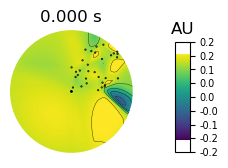

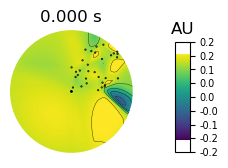

In [129]:
import numpy as np
import mne

# Replace the following variables with your actual data
num_channels = 32  # Number of EEG channels
mean_hurst_exponent = hurst_exponents  # Array with mean Hurst exponent value for each channel
grid_size = 10

# Generate random scalp positions with a small random offset to avoid overlapping
offset = 0.1
scalp_positions = np.random.uniform(0, grid_size - offset, size=(num_channels, 2))
scalp_positions += np.random.uniform(0, offset, size=(num_channels, 2))
scalp_positions_3d = [(*pos, 0) for pos in scalp_positions]

# Step 1: Organize mean Hurst exponent values into a 2D grid corresponding to scalp positions
# Initialize the mean_hurst_exponent_map with NaN values to avoid index out of bounds error
mean_hurst_exponent_map = np.full((grid_size, grid_size), np.nan)

for i in range(num_channels):
    x, y = scalp_positions[i]
    mean_hurst_exponent_map[int(x), int(y)] = mean_hurst_exponent[i]

# Step 2: Plot the topographical map using MNE-Python
# Create an MNE info object with channel names and montage information
channel_names = [f'EEG {i+1}' for i in range(num_channels)]
sampling_rate = 1000  # Replace with your actual sampling rate
info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types='eeg')

# Create a digitization object and add electrode locations to it
dig = mne.channels.make_dig_montage(ch_pos=dict(zip(channel_names, scalp_positions_3d)), coord_frame='head')

# Add the digitization to the info object
info.set_montage(dig)

# Create the EvokedArray with your mean Hurst exponent data
data = mean_hurst_exponent[:, np.newaxis]
evoked = mne.EvokedArray(data, info)

# Plot the topographical map of mean Hurst exponent values
evoked.plot_topomap(times=0, scalings=1.0, cmap='viridis')

# Consider performing statistical tests (e.g., ANOVA, t-test) to assess group differences or condition-related variations in the mean Hurst exponent values

# Load saved MFDFA results and plot them

In [20]:
# Load the MFDFA results from the file
save_dir = '/home/vincent/AAA_projects/MVCS/Neuroscience/MFDFA/'  # the directory path where you saved the file
mfdfa_results = np.load(save_dir + 'MFDFA_results.npy', allow_pickle=True)

In [17]:
# Check if mfdfa_results has data for each channel
num_channels = mfdfa_results.shape[0]
if num_channels == 0:
    print("Error: MFDFA results do not have data for any channel.")
else:
    # Initialize an array to store the Hurst exponent for each channel
    hurst_exponents = np.zeros(num_channels)

    # Loop over each channel
    for ch in range(num_channels):
        # Extract the scale and fluctuation parameters for the current channel
        scale, fluct, _, _ = saved_mfdfa_results[ch]

        # Fit a line in log-log space to get the Hurst exponent
        H_hat = np.polyfit(np.log(scale)[4:20], np.log(fluct)[4:20], 1)[0]

        # Store the Hurst exponent for the current channel
        hurst_exponents[ch] = H_hat

    # Visualize the results
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, num_channels + 1), hurst_exponents)
    plt.xlabel('Channel')
    plt.ylabel('Hurst Exponent')
    plt.title('Hurst Exponent for Each EEG Channel')
    plt.show()

IndexError: tuple index out of range

# MFDFA Feature Extraction and Data Formatting

In [30]:
# Define the number of timesteps in each input sequence
timesteps = 100

# Create continuous data by concatenating all scale and fluctuation arrays
continuous_scale = np.concatenate([scale for scale, _ in padded_mfdfa_results])
continuous_fluct = np.concatenate([fluct for _, fluct in padded_mfdfa_results])

# Initialize X data
cnn_X_data = []
rnn_X_data = []

# Create overlapping sequences
for i in range(len(continuous_scale) - timesteps):
    scale_seq = continuous_scale[i : i + timesteps]
    fluct_seq = continuous_fluct[i : i + timesteps]
    seq = np.column_stack([scale_seq, fluct_seq])
    
    cnn_X_data.append(seq.flatten())  # Flatten sequence for CNN
    rnn_X_data.append(seq)  # Keep sequence shape for RNN

# Convert lists to numpy arrays
cnn_X_data = np.array(cnn_X_data)
rnn_X_data = np.array(rnn_X_data)

print("Shape of cnn_X_data:", cnn_X_data.shape)
print("Shape of rnn_X_data:", rnn_X_data.shape)


Shape of cnn_X_data: (860, 5100)
Shape of rnn_X_data: (860, 100, 51)


In [31]:
# Print shape and first elements of CNN data
print("Shape of cnn_X_data:", cnn_X_data.shape)
print("First element of cnn_X_data:\n", cnn_X_data[0])

# Print shape and first elements of RNN data
print("Shape of rnn_X_data:", rnn_X_data.shape)
print("First element of rnn_X_data:\n", rnn_X_data[0])

Shape of cnn_X_data: (860, 5100)
First element of cnn_X_data:
 [0.00000000e+00 0.00000000e+00 3.50020883e-08 ... 1.02874780e-02
 1.06212100e-02 1.09375542e-02]
Shape of rnn_X_data: (860, 100, 51)
First element of rnn_X_data:
 [[0.00000000e+00 0.00000000e+00 3.50020883e-08 ... 1.48880730e-04
  1.60519608e-04 1.72424775e-04]
 [1.00050025e-04 7.20844984e-07 8.06273925e-07 ... 1.81094506e-04
  1.94758141e-04 2.08734901e-04]
 [3.00150075e-04 2.49774851e-06 2.63861602e-06 ... 2.51222770e-04
  2.70407111e-04 2.90373884e-04]
 ...
 [2.60130065e-03 3.42822519e-06 3.53222373e-06 ... 8.57237580e-03
  8.87304395e-03 9.16003688e-03]
 [3.50175088e-03 4.44041983e-06 4.55638833e-06 ... 1.00475252e-02
  1.03789221e-02 1.06936306e-02]
 [4.70235118e-03 5.62150246e-06 5.74783045e-06 ... 1.02874780e-02
  1.06212100e-02 1.09375542e-02]]


# Save MFDFA X data for CNN and RNN as numpy

In [16]:
# Define the directory paths where you want to save the data
cnn_save_dir = '/home/vincent/AAA_projects/MVCS/Neuroscience/CNN_data/'
rnn_save_dir = '/home/vincent/AAA_projects/MVCS/Neuroscience/RNN_data/'

# Save CNN data
np.save(cnn_save_dir + 'cnn_mfdfa_X_df.npy', cnn_X_data)

# Save RNN data
np.save(rnn_save_dir + 'rnn_mfdfa_X_df.npy', rnn_X_data)

# Load  Hurst exponents as numpy

In [18]:
# Load the saved Hurst exponents from the file
hurst_exponents_npy = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/HurstExponents/hurst_exponents.npy')

# Load MFDFA RNN X data as numpy

In [22]:
# Load data
rnn_mfdfa_X_df_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/RNN_data/'

# Load RNN data
rnn_mfdfa_X_df_npy = np.load(rnn_mfdfa_X_df_path + 'rnn_mfdfa_X_df.npy')

# Load MFDFA CNN X data as numpy

In [ ]:
# Load data
cnn_save_dir = '/home/vincent/AAA_projects/MVCS/Neuroscience/CNN_data/'

# Load CNN data
rnn_mfdfa_X_df_npy = np.load(rnn_mfdfa_X_df_path + 'cnn_mfdfa_X_df.npy')

# Convert RNN, CNN X data, and Hurst exp data from numpy to df

In [38]:
# Display the shapes
print("Shape of cnn_mfdfa_X_df:", cnn_mfdfa_X_df.npy.shape)
print("Shape of rnn_mfdfa_X_df.npy:", rnn_mfdfa_X_df.npy.shape)

# Convert the 3D CNN data to a DataFrame
cnn_X_df = pd.DataFrame(cnn_mfdfa_X_df)

# Convert the 3D RNN data to a list of DataFrames with generic column labels
rnn_X_df = [pd.DataFrame(time_series) for time_series in rnn_mfdfa_X_df.npy]

# Display the head of the first DataFrame in the list
print("cnn_X_df:")
print(cnn_X_df.head())
print()

# Display the head of the first 5 DataFrames in the list
print("rnn_X_df:")
for i, df in enumerate(rnn_X_df[:5]):
    print(f"DataFrame {i+1}:")
    print(df.head())
    print()

# Assuming hurst_exponents_npy has shape (32,)
# Convert Numpy array to DataFrame
hurst_exponents_df = pd.DataFrame(hurst_exponents_npy)

print("hurst_exponents:")
print(hurst_exponents_df.head())

Shape of cnn_X_data: (860, 5100)
Shape of rnn_X_data: (860, 100, 51)
cnn_X_df:
     0             1             2             3             4     \
0  0.0000  0.000000e+00  3.500209e-08  7.687994e-08  1.273251e-07   
1  0.0001  7.208450e-07  8.062739e-07  9.023169e-07  1.009805e-06   
2  0.0003  2.497749e-06  2.638616e-06  2.787348e-06  2.943969e-06   
3  0.0005  4.023184e-06  4.207777e-06  4.401253e-06  4.603944e-06   
4  0.0009  6.903312e-06  7.153461e-06  7.418168e-06  7.697934e-06   

           5             6             7             8             9     ...  \
0  1.884323e-07  2.627076e-07  3.529606e-07  4.619666e-07  5.917862e-07  ...   
1  1.129261e-06  1.260744e-06  1.403757e-06  1.557257e-06  1.719825e-06  ...   
2  3.108491e-06  3.280934e-06  3.461341e-06  3.649793e-06  3.846420e-06  ...   
3  4.816177e-06  5.038258e-06  5.270445e-06  5.512933e-06  5.765839e-06  ...   
4  7.993139e-06  8.304015e-06  8.630621e-06  8.972824e-06  9.330300e-06  ...   

       5090      5091    

# Load MFDFA CNN X data as numpy

In [28]:
# Define file paths
cnn_save_dir = '/home/vincent/AAA_projects/MVCS/Neuroscience/CNN_data/'
cnn_mfdfa_X_data_path = cnn_save_dir + 'cnn_mfdfa_X_data.npy'

# Load the data as numpy arrays
cnn_mfdfa_X_data = np.load(cnn_mfdfa_X_data_path)
cnn_mfdfa_Y_data = np.load(cnn_mfdfa_Y_data_path)

# Now you have the data as numpy arrays
print("cnn_mfdfa_X_data:")
print(cnn_mfdfa_X_data)

print("cnn_mfdfa_Y_data:")
print(cnn_mfdfa_Y_data)

cnn_mfdfa_X_data:
[[[0.00000000e+00 0.00000000e+00 3.50020883e-08 ... 1.48880730e-04
   1.60519608e-04 1.72424775e-04]
  [1.00050025e-04 7.20844984e-07 8.06273925e-07 ... 1.81094506e-04
   1.94758141e-04 2.08734901e-04]
  [3.00150075e-04 2.49774851e-06 2.63861602e-06 ... 2.51222770e-04
   2.70407111e-04 2.90373884e-04]
  ...
  [5.91895948e-01 2.65297556e-03 2.75874450e-03 ... 5.52352885e-01
   5.76860492e-01 6.00504758e-01]
  [7.69284642e-01 4.81536991e-03 4.96171933e-03 ... 7.25410306e-01
   7.55047727e-01 7.83563658e-01]
  [1.00000000e+00 8.42008260e-03 8.60116123e-03 ... 9.34027641e-01
   9.67772183e-01 1.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 3.69707482e-08 ... 1.61467172e-04
   1.68815702e-04 1.76239232e-04]
  [1.00050025e-04 5.31267875e-07 6.21884324e-07 ... 2.29331598e-04
   2.38569405e-04 2.47610948e-04]
  [3.00150075e-04 2.33442819e-06 2.45704109e-06 ... 4.04356107e-04
   4.19903355e-04 4.34902090e-04]
  ...
  [5.91895948e-01 2.75757024e-03 2.89119975e-03 ... 5.03398

# Save MFDFA CNN X data as df

In [40]:
# Define the save directory
cnn_save_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/CNN_data/'

# Save the CNN X data
cnn_X_df.to_csv(cnn_save_path + 'cnn_X_df.csv', index=False)

# Save MFDFA RNN X data and Hurst exp as DF

In [47]:
# Save rnn_mfdfa_X_df
rnn_data_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/RNN_data/'
for i, df in enumerate(rnn_X_df):
    df.to_csv(f"{rnn_data_path}rnn_X_df_{i}.csv", index=False)

# Save hurst_exponents_df
hurst_exponents_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/HurstExponents/'
hurst_exponents_df.to_csv(f"{hurst_exponents_path}hurst_exponents_df.csv", index=False)

# Make the MFDFA RNN X DF 1 file instead of 860

In [48]:
# Combine the list of DataFrames into a single 3D DataFrame
rnn_X_df_combined = np.stack(rnn_X_data)

# The shape of rnn_X_df_combined should be (860, 100, 51)
print("Shape of rnn_X_df_combined:", rnn_X_df_combined.shape)

# Save the combined 3D DataFrame to a CSV file
rnn_data_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/RNN_data/'
np.save(f"{rnn_data_path}rnn_X_data_combined.npy", rnn_X_df_combined)

Shape of rnn_X_df_combined: (860, 100, 51)
